# Convolutional Neural Network for QPE

Let's test our QPE approach with CNN.

In [72]:
import os, csv, logging, argparse, glob, h5py, pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Dense, Flatten, Activation
from tensorflow.keras.layers import Conv2D, AveragePooling2D, MaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import regularizers
from tensorflow.keras import initializers
from tensorflow.keras.utils import normalize, to_categorical

# Parameters
nLayer = 6                      # 6 10-min dbz for an hour
nY = 275                        # y-dimension of dbz data
nX = 162                        # x-dimension of dbz data
batchSize = 128                 # Batch size for training / testing

# Load input/output data for model
def loadIOTab(srcx, srcy, dropna=False):
    import pandas as pd
    # Read raw input and output
    #logging.info("Reading input X from: "+ srcx)
    print("Reading input X from: "+ srcx)
    xfiles = []
    for root, dirs, files in os.walk(srcx): 
        for fn in files: 
            if fn.endswith('.npy'): 
                 xfiles.append({'date':fn.replace('.npy',''), 'xuri':os.path.join(root, fn)})
    xfiles = pd.DataFrame(xfiles)
    print("... read input size: "+str(xfiles.shape))
    #logging.info("Reading output Y from: "+ srcy)
    print("Reading output Y from: "+ srcy)
    yraw = pd.read_csv(srcy, encoding='utf-8')
    yraw['date'] = yraw['date'].apply(str)
    print("... read output size: "+str(yraw.shape))
    # Create complete IO-data
    print("Pairing X-Y and splitting training/testing data.")
    iotab = pd.merge(yraw, xfiles, on='date', sort=True)
    print("... data size after merging: "+str(iotab.shape))
    # Dro NA if specified
    if dropna:
        print('Dropping records with NA')
        iotab = iotab.dropna()
        print("... data size after dropping-NAs: "+str(iotab.shape))
    # Done
    return(iotab)

# CNN
def init_model_reg(input_shape):
    """
    :Return: 
      Newly initialized model (regression).
    :param 
      int input_shape: The number of variables to use as input features.
    """
    # Input layer
    inputs = Input(shape=input_shape)
    # blovk1: CONV -> CONV -> MaxPooling
    x = Conv2D(filters=8, kernel_size=(3,3), activation='relu', name='block1_conv1', data_format='channels_first')(inputs)
    x = MaxPooling2D((2,2), name='block1_pool', data_format='channels_first')(x)
    x = Dropout(0.5)(x)
    # block2: CONV -> CONV -> MaxPooling
    x = Conv2D(16, (3,3), activation='relu', name='block2_conv1',data_format='channels_first')(x)
    x = MaxPooling2D((2,2), name='block2_pool', data_format='channels_first')(x)
    x = Dropout(0.5)(x)
    # Output block: Flatten -> Dense -> Dense -> softmax output
    x = Flatten()(x)
    x = Dense(8, activation='relu', name='fc1')(x)
    x = Dropout(0.5)(x)
    x = Dense(4, activation='relu', name='fc2')(x)
    # Output layer
    out = Dense(1, activation='linear', name='main_output')(x)
    # Initialize model
    model = Model(inputs = inputs, outputs = out)
    # Define compile parameters
    adam = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    #sgd = SGD(lr=0.01, momentum=1e-8, decay=0.001, nesterov=True)#, clipvalue=1.)
    model.compile(loss='mse', optimizer=adam, metrics=['mae','cosine_similarity'])
    return(model)

# Read uris containing QPESUMS data in the format of 6*275*162 
def loadDBZ(flist, to_log=False):
    ''' Load a list a dbz files (in npy format) into one numpy array. '''
    xdata = []
    for f in flist:
        tmp = np.load(f)
        # Append new record
        if tmp is not None:            # Append the flattened data array if it is not None
            xdata.append(tmp.flatten())
    x = np.array(xdata, dtype=np.float32)
    # Convert to log space if specified
    if to_log:
        x = np.log(x+1)
    # done
    return(x)

def y_to_log(y):
    ''' Convert the y to log(y+1). '''
    ylog = np.log(y+1).astype(np.float32)
    return(ylog)

def log_to_y(y):
    ''' Convert the predicted y in log-scale back to original scale. '''
    yori = (np.exp(y.flatten())-1.0).astype(np.float32)
    yori[yori<0.5] = 0.                          # Set the minimal values to 0.
    return(yori)

def data_generator_reg(iotab, batch_size, ylab='y', logy=False):
    ''' Data generator for batched processing. '''
    nSample = len(iotab)
    y = np.array(iotab[ylab], dtype=np.float32).reshape(nSample, 1)
    #print(y[:5])
    # This line is just to make the generator infinite, keras needs that    
    while True:
        batch_start = 0
        batch_end = batch_size
        while batch_start < nSample:
            limit = min(batch_end, nSample)
            X = loadDBZ(iotab['xuri'][batch_start:limit])/100.
            if logy:
                Y = y_to_log(y[batch_start:limit])
            else:
                Y = y[batch_start:limit]
            #print(X.shape)
            yield (X,Y) #a tuple with two numpy arrays with batch_size samples     
            batch_start += batch_size   
            batch_end += batch_size
    # End of generator

# Function to give report
def report_evaluation(y_true, y_pred, verbose=0):
    import sklearn.metrics as metrics
    # Calculate measures
    results = {}
    results['y_true_mean'] = y_true.mean()
    results['y_true_var'] = y_true.var()
    results['y_pred_mean'] = y_pred.mean()
    results['y_pred_var'] = y_pred.var()
    results['rmse'] = np.sqrt(metrics.mean_squared_error(y_true,y_pred))
    if y_pred.var()<=10e-8:
        results['corr'] = 0
    else:
        results['corr'] = np.corrcoef(y_true,y_pred)[0,1]
    # Print results if verbose > 0
    if verbose>0:
        if verbose>1:
            print('Mean of y_true: ' + str(results['y_true_mean']))
            print('Variance of y_true: ' + str(results['y_true_var']))
            print('Mean of y_pred: ' + str(results['y_pred_mean']))
            print('Variance of y_pred: ' + str(results['y_pred_var']))
        print('RMSE: ' + str(results['rmse']))
        print('Corr: ' + str(results['corr']))
    # Return results
    return(results)

In [4]:
def generate_samples(dinfo, prec_bins=[0, 1, 5, 10, 20, 40, 500], num_epoch=100, shuffle=True):
    '''Create weighted sampling list'''
    # Analysis the Precipitation
    prec_hist = np.histogram(dinfo['y'], bins=prec_bins)
    p = 1/(prec_hist[0]/prec_hist[0][-1])           # Calculate probability
    p = p/sum(p)                                    # Normalize the probability
    n = sum(prec_hist[0])*num_epoch                 # Total number of samples
    nrep = np.round(n*p/prec_hist[0]).astype(int)   # Convert to numbers of sampling
    # Categorize precipitation by specified bins
    dinfo['prec_cat'] = np.digitize(dinfo['y'], bins=prec_bins)
    print(dinfo['prec_cat'].value_counts())
    # Repeat sampling by p
    for icat in range(1,len(prec_bins)):
        repeat_n = nrep[icat-1]
        tmp = dinfo.loc[dinfo['prec_cat']==icat,:]
        print('Append data category: '+str(icat)+' for '+ str(repeat_n) +' times with size '+str(tmp.shape))
        for j in range(int(repeat_n)):
            dinfo = dinfo.append(tmp, ignore_index=True)
    # Shuffle new dataset if specified
    if shuffle:
        dinfo = dinfo.sample(frac=1)#.reset_index(drop=True)
    #
    return(dinfo)

In [86]:
import os
srcx = '../dbz_2016070609/'
# Input
print("Reading input X from: "+ srcx)
xfiles = []
for root, dirs, files in os.walk(srcx): 
    for fn in files: 
        if fn.endswith('.npy'): 
             xfiles.append({'date':fn.replace('.npy',''), 'xuri':os.path.join(root, fn)})
xfiles = pd.DataFrame(xfiles)
print(xfiles.shape)
xfiles.head()

# Output
srcy = './data/t1hr.csv'
yraw = pd.read_csv(srcy, encoding='utf-8')
t1hr = yraw.iloc[:,1:]
t1hr_max = t1hr.max(axis=1)
yraw['date'] = yraw['date'].apply(str)
yraw['y'] = t1hr_max
print("... read output size: "+str(yraw.shape))

print("Pairing X-Y and splitting training/testing data.")
iotab = pd.merge(yraw, xfiles, on='date', sort=True)
print("... data size after merging: "+str(iotab.shape))
iotab.head()

newiotab = generate_samples(iotab, num_epoch=10)
print(iotab.shape)
print(newiotab.shape)
print(newiotab['prec_cat'].value_counts())
newiotab.head()

Reading input X from: ../dbz_2016070609/
(92, 2)
... read output size: (35064, 47)
Pairing X-Y and splitting training/testing data.
... data size after merging: (92, 48)
1    30
2    25
3    18
4    12
5     5
6     2
Name: prec_cat, dtype: int64
Append data category: 1 for 1 times with size (30, 49)
Append data category: 2 for 2 times with size (25, 49)
Append data category: 3 for 3 times with size (18, 49)
Append data category: 4 for 7 times with size (12, 49)
Append data category: 5 for 40 times with size (5, 49)
Append data category: 6 for 252 times with size (2, 49)
(92, 49)
(1014, 49)
6    506
5    205
4     96
2     75
3     72
1     60
Name: prec_cat, dtype: int64


,date,C0A580,C0A970,466940,C0A540,C0A550,C0A9A0,C0AC60,C0A870,466920,...,C0A560,C0A950,C0A940,C0A570,C0A980,C0A9C0,C0AD40,y,xuri,prec_cat
591,2016070816,0.5,0.0,3.5,21.0,52.5,14.0,NaN,16.0,2.9,...,3.5,0.0,1.0,NaN,9.0,32.0,0.0,52.5,../dbz_2016070609/2016070816.npy,6
265,2016070802,0.5,0.0,0.5,2.5,1.5,0.0,0.0,0.0,0.0,...,12.0,0.0,1.0,3.0,0.0,0.0,0.0,12.0,../dbz_2016070609/2016070802.npy,4
904,2016070815,6.0,0.0,NaN,44.0,18.0,6.5,0.5,0.0,6.0,...,0.5,NaN,0.0,4.0,3.0,0.5,1.5,44.0,../dbz_2016070609/2016070815.npy,6
359,2016070920,5.5,0.0,5.1,8.5,3.0,12.5,1.0,17.0,7.5,...,2.0,0.0,15.5,5.0,5.0,12.5,1.5,31.5,../dbz_2016070609/2016070920.npy,5
140,2016070903,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,1.0,0.0,0.0,0.5,NaN,0.0,0.0,1.0,../dbz_2016070609/2016070903.npy,2


In [99]:

model = init_model_reg((nLayer, nY, nX))
model.summary()
steps_train = np.ceil(newiotab.shape[0]/128)

hist = model.fit_generator(data_generator_reg(newiotab, 128, ylab='y'), steps_per_epoch=steps_train, epochs=20, max_queue_size=128, verbose=0)

print(pd.DataFrame(hist.history))

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 6, 275, 162)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 8, 273, 160)       440       
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 8, 136, 80)        0         
_________________________________________________________________
dropout_57 (Dropout)         (None, 8, 136, 80)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 134, 78)       1168      
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 67, 39)        0         
_________________________________________________________________
dropout_58 (Dropout)         (None, 16, 67, 39)        0  

In [100]:
steps_test = np.ceil(newiotab.shape[0]/16)
y_pred = model.predict_generator(data_generator_reg(newiotab.iloc[:116,:], 16, ylab='y'), steps=steps_train, verbose=0)
yp = log_to_y(y_pred)
yt = np.array(newiotab['y'].iloc[:116])
print(y_pred.shape)

ys = pd.DataFrame({'y': yt, 'y_pred_log': y_pred.flatten(), 'y_pred':yp}) 
tmp = report_evaluation(yt, y_pred.flatten())
print(tmp)
print(hist)

(116, 1)
{'y_true_mean': 30.679310344827588, 'y_true_var': 382.7638822829964, 'y_pred_mean': 12.814831, 'y_pred_var': 59.935547, 'rmse': 21.48112880063615, 'corr': 0.9916592046058613}


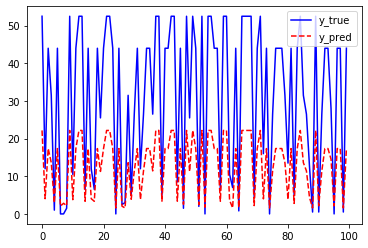

W1027 13:59:23.681315 14572 legend.py:1282] No handles with labels found to put in legend.


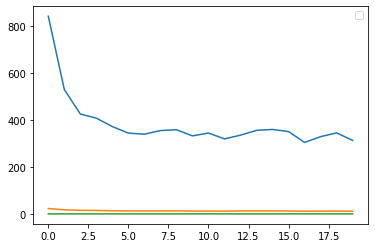

In [101]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(ys['y'][:100], 'b-', label='y_true')
plt.plot(ys['y_pred_log'][:100], 'r--', label='y_pred')
plt.legend()
plt.show()

plt.plot(pd.DataFrame(hist.history))
plt.legend()
plt.show()

In [85]:
print(ys.iloc[:30,:])

       y  y_pred_log        y_pred
0   20.5    6.188415  4.860735e+02
1   44.0   14.410490  1.812993e+06
2   44.0   14.410490  1.812993e+06
3   17.0    6.298742  5.428875e+02
4   52.5   17.641331  4.587041e+07
5    0.0    8.681322  5.890831e+03
6   52.5   17.641331  4.587041e+07
7    0.0    1.594984  3.928250e+00
8   52.5   17.641331  4.587041e+07
9   12.5    4.007710  5.402073e+01
10  12.0    3.936441  5.023592e+01
11   5.0    9.139777  9.317688e+03
12  20.5    6.188415  4.860735e+02
13  17.5    6.332276  5.614352e+02
14   7.0    8.196860  3.628537e+03
15  44.0   14.410490  1.812993e+06
16  44.0   14.410490  1.812993e+06
17  25.5    8.942075  7.646046e+03
18   7.0    3.382911  2.845640e+01
19  52.5   17.641331  4.587041e+07
20  44.0   14.410490  1.812993e+06
21   1.5   10.863456  5.223127e+04
22  44.0   14.410490  1.812993e+06
23  52.5   17.641331  4.587041e+07
24  44.0   14.410490  1.812993e+06
25  12.5    4.007710  5.402073e+01
26  26.5    9.950830  2.096861e+04
27  52.5   17.641331

## Summary

- The trend seems correct though the magnitude is smaller.
- Effect of increasing epochs seems stopped around 15
- 